In [1]:
import sys
sys.path.insert(0,'../src')
from v0 import *

In [2]:
STREET_SHAPE_FOLDER = '/home/adelsondias/Downloads/newcastle_streets/'
LSOA_SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_30days/'

### Sensor's features ingestion

In [3]:
variables =  {
        'sensors':['NO2','Temperature','O3','CO'],
        'exogenous':['primary','trunk','motorway','construction','residential','traffic_signals','crossing','bus_stop','day','dow','hour']
}
metadata, osmf, sensors = load_data(LSOA_SHAPE_FOLDER, DATA_FOLDER)
sensors, metadata = resampling_sensors(sensors, metadata, variables, 'H')

In [6]:
# sensors feature ingestion
zx, zi = load_data__(DATA_FOLDER)
zx, zi = resampling_sensors__(zx, zi, 'H')

### Model training

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

zxs = MinMaxScaler().fit_transform(zx)
gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, max_features=None).fit(zxs,np.log(zi['Value']))

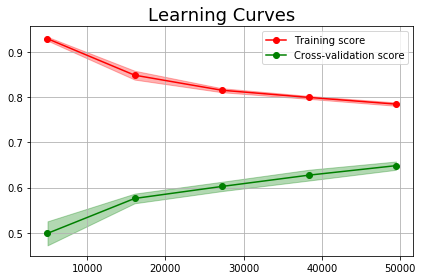

In [82]:
# plot_learning_curves(gb,zxs,np.log(zi['Value']))
train_sizes, train_scores, test_scores = learning_curve(
                                            gb, zxs,np.log(zi['Value']), scoring='r2', n_jobs=2,
                                            cv=ShuffleSplit(n_splits=5, test_size=0.1, random_state=0),
                                            train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.3,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.title('Learning Curves', fontsize=18)
#plt.xlabel('n_estimators={} max_depth={}'.format(200,5))
plt.tight_layout()
plt.show()

### Mesh features ingestion

In [4]:
mesh = pd.read_csv(DATA_FOLDER+'mesh_valid-regions.csv',index_col=0)
mesh['geometry'] = [shapely.geometry.Point(xy) for xy in zip(mesh.lon, mesh.lat)]
mesh = gpd.GeoDataFrame(mesh)

In [7]:
# def mesh_ingestion()
idx = pd.IndexSlice
t = pd.to_datetime('2018-07-01 07:00:00')


zmesh = pd.DataFrame(index=mesh.index, columns=zx.columns)
for m in range(mesh.shape[0]):
    i = mesh.iloc[m]
    for var in variables['sensors']:
        st = sensors.loc[idx[var,:,t]]
        closest = metadata.loc[st.index.get_level_values(1),'geometry'].apply(lambda x: x.distance(i['geometry'])).nsmallest(5)
        closest = st.loc[idx[var,closest.index,t],:].join(closest)
        zmesh.loc[i.name,var] = closest['Value'].values
        zmesh.loc[i.name,"d_{}".format(var)] = closest['geometry'].values

In [9]:
osm_df2 = osm_features(STREET_SHAPE_FOLDER, LSOA_SHAPE_FOLDER, mesh, 
                     conf={
                         'method':'distance', 
                         'lines':['primary','trunk','motorway'], 
                         'points':['traffic_signals']}
)
zmesh[['primary','trunk','motorway','traffic_signals']] = osm_df2

In [20]:
zmesh['hour'] = t.hour
zmesh['day'] = t.day
zmesh['dow'] = t.dayofweek
zmesh.head()

,NO2,NO2,NO2,NO2,NO2,d_NO2,d_NO2,d_NO2,d_NO2,d_NO2,...,d_CO,d_CO,d_CO,hour,dow,day,primary,trunk,motorway,traffic_signals
225,35.0731,28.2573,25.9871,34.3061,39.6497,0.0257949,0.0253511,0.0257335,0.024985,0.025292,...,0.0257335,0.024985,0.025292,7,6,1,391.853272,34.311356,26.041052,193.277120
226,642.87,32.1953,28.2573,34.3061,39.6497,0.0204777,0.0207071,0.020737,0.0192531,0.0196187,...,0.0207071,0.0192531,0.0196187,7,6,1,461.882409,36.476274,29.767130,442.493052
227,642.87,32.1953,34.3061,26.7816,39.6497,0.0154512,0.0155721,0.0138594,0.0156759,0.0143203,...,0.0155721,0.0138594,0.0143203,7,6,1,379.120962,39.048322,35.798693,378.431506
273,35.0731,30.6576,28.2573,25.9871,34.3061,0.0354617,0.0360541,0.0349323,0.0352249,0.036366,...,0.0349323,0.0352249,0.036366,7,6,1,627.601963,37.819919,20.938867,359.133729
274,35.0731,30.6576,28.2573,25.9871,34.3061,0.0297959,0.0303599,0.0292861,0.0296058,0.0303146,...,0.0292861,0.0296058,0.0303146,7,6,1,1251.093952,38.280250,23.670178,300.203685


# Finally... predict!

In [61]:
y_pred = pd.DataFrame(np.exp(gb.predict(MinMaxScaler().fit_transform(zmesh))), 
                      index=mesh.index, columns=['pred'])
y_pred.head()

,pred
225,9.654101
226,10.595885
227,22.028522
273,20.737118
274,12.987754


### and plot

In [54]:
lon = np.linspace(-1.8, -1.5, 50)
lat = np.linspace(54.95, 55.08, 50)
lonv, latv = np.meshgrid(lon,lat)
Z = np.zeros(lonv.shape[0]*lonv.shape[1]) - 9999

Z[mesh.index.values] = y_pred.values.ravel()
Z = Z.reshape(lonv.shape)

In [73]:
# shapes
lsoa = gpd.read_file(LSOA_SHAPE_FOLDER+'Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}
newcastle = gpd.GeoSeries(shapely.ops.cascaded_union(lsoa['geometry']))
lines = gpd.read_file(STREET_SHAPE_FOLDER+'newcastle_streets.shp')
lines = lines[(lines['highway']!='') & (lines['highway']!='unclassified')]
lines = gpd.sjoin(lines, gpd.GeoDataFrame(geometry=newcastle, crs={'init': 'epsg:4326', 'no_defs': True}), how='inner' ,op='intersects')[lines.columns]

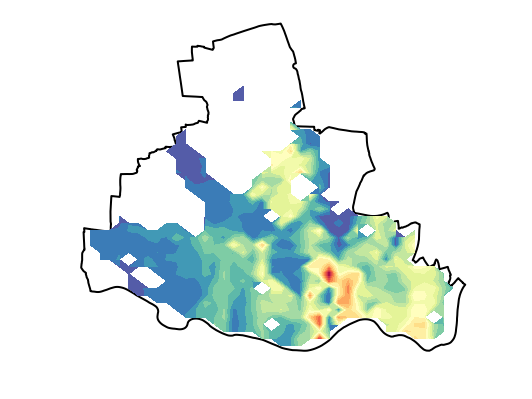

In [78]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7.5,5.5))

newcastle.plot(ax=axes,color='white', edgecolor='black',linewidth=2)
# metadata.plot(ax=axes,color='white', edgecolor='black',linewidth=2,zorder=10)
plt.contourf(lonv, latv, Z,levels=np.linspace(0, Z.max(), 20), cmap=plt.cm.Spectral_r,alpha=1)
plt.axis('off')
plt.tight_layout()
if True:
    plt.savefig(DATA_FOLDER+'plots/prediction.svg', format='svg', dpi=600)